1. EDA


 top 2 lines from corpus 
          id                                              title  \
0  0704.0038  The discrete dipole approximation: an overview...   
1  0704.0057  High-spin to low-spin and orbital polarization...   

                                            abstract  
0    We present a review of the discrete dipole a...  
1    We study the interplay of crystal field spli...  

 top 2 test quaries 
                id                                           abstract  \
0       2412.16732    A new platinate was recently discovered when...   
1  nucl-th/9602019    The production cross sections of various fra...   

                                               query  
0  What unique composition and decomposition beha...  
1  How does the inclusion of statistical decay af...  

Number of articles: 98213
Number of test quaries: 1000

 stastics on lenghts of the texts in corpus (in words)
count    98213.000000
mean       153.664881
std         64.145051
min          4.000000

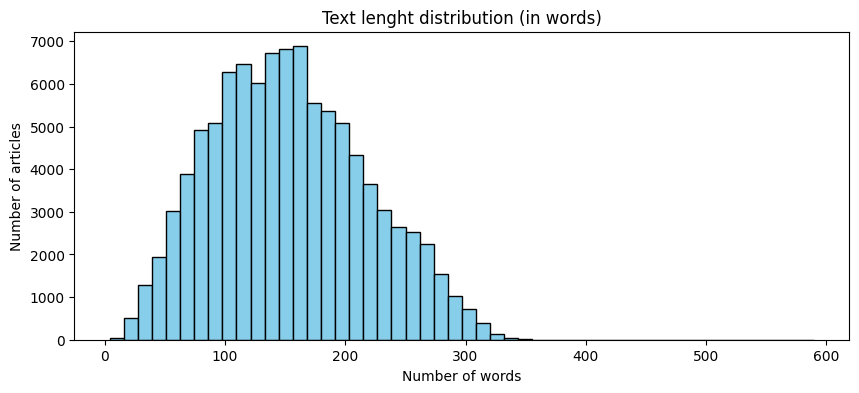

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

with open('arxiv-metadata-s.json', 'r', encoding='utf-8') as f:
  data = json.load(f)

corpus_df = pd.DataFrame(data)
test_df = pd.read_csv('test_sample.csv')

# vizualization
print("\n top 2 lines from corpus ")
print(corpus_df[['id', 'title', 'abstract']].head(2))

print("\n top 2 test quaries ")
print(test_df.head(2))

print(f"\nNumber of articles: {len(corpus_df)}")
print(f"Number of test quaries: {len(test_df)}")

# text length analysis
# sorted by title + abstract
corpus_df['full_text'] = corpus_df['title'] + ". " + corpus_df['abstract']
corpus_df['text_len_words'] = corpus_df['full_text'].apply(lambda x: len(str(x).split()))

print("\n stastics on lenghts of the texts in corpus (in words)")
print(corpus_df['text_len_words'].describe())

plt.figure(figsize=(10, 4))
plt.hist(corpus_df['text_len_words'], bins=50, color='skyblue', edgecolor='black')
plt.title('Text lenght distribution (in words)')
plt.xlabel('Number of words')
plt.ylabel('Number of articles')
plt.show()

2. Retrieval system and its results

In [2]:
!pip install langchain-community langchain_huggingface faiss-cpu
import pandas as pd
from langchain_community.document_loaders import DataFrameLoader
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.1
    Uninstalling langchain-core-1.2.1:
      Successfully uninstalled langchain-core-1.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-

In [3]:
# DataFrameLoader -- professianal way to put pandas into LangChain
loader = DataFrameLoader(corpus_df, page_content_column="full_text")

source_documents = loader.load() # LangChain automatically puts 'id', 'title' and 'abstract' into metadata for every doc

print(f"Number of docs prepared: {len(source_documents)}")
print(f"metadata check: {source_documents[0].metadata}")

# loading a model for embedding construction
embeddings_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True, 'batch_size': 32})

# building FAISS index for articles in corpus
print("FIASS index construction: ")
vectorstore = FAISS.from_documents(source_documents, embeddings_model)

# retriever is set to return top 5 results
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

print("The index is built")


Number of docs prepared: 98213
metadata check: {'id': '0704.0038', 'submitter': 'Maxim A. Yurkin', 'authors': 'Maxim A. Yurkin, Alfons G. Hoekstra', 'title': 'The discrete dipole approximation: an overview and recent developments', 'comments': '36 pages, 1 figure; added several corrections according to the\n  published erratum except for Eq.(5) (it was correct in the original paper)', 'journal-ref': 'J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 (2007); Erratum:\n  J.Quant.Spectrosc.Radiat.Transf. 171, 82-83 (2016)', 'doi': '10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.2015.11.025', 'report-no': None, 'categories': 'physics.optics physics.comp-ph', 'license': 'http://creativecommons.org/licenses/by-nc-nd/4.0/', 'abstract': '  We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped particles. We\nput the method in historical context and discuss recent developments, taking\nthe viewpoint of a general fra

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

FIASS index construction: 
The index is built


In [4]:
# downloading the index
index_path = "faiss_index_bge_large"
vectorstore.save_local(index_path)

print(f"The index is saved to {index_path}")

The index is saved to faiss_index_bge_large


In [5]:
# Sanity Check
test_query = "quantum computing"
results = retriever.invoke(test_query)

print(f"\nTest quary: '{test_query}'")
print(f"Found overall: {len(results)}")
print(f"Top-1: {results[0].page_content}")


Test quary: 'quantum computing'
Found overall: 5
Top-1: Quantum Computation Relative to Oracles.   This paper has been withdrawn by Christino Tamon and Tomoyuki Yamakami
because of errors of the main theorems. An erratum appeared in the Proceedings
of the UMC 2000 Conference published by Springer.



In [6]:
import time
import numpy as np
from tqdm.auto import tqdm

def evaluate_and_profile(test_df, vectorstore, embeddings_model):
    """
    Dataset through a retriever, calculates MRR@5 and measures speed.
    """

    mrr_scores = []

    print(f"Estimation for {len(test_df)} quaries: ")

    embedding_times = []
    search_times = []

    for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
        query = row['query']
        target_id = str(row['id']).strip() # correct answer

        # Building embeddings time estimation
        t0 = time.time()
        query_vector = embeddings_model.embed_query(query)
        t1 = time.time()
        embedding_times.append(t1 - t0)

        # Search articles time estimation
        t2 = time.time()
        retrieved_docs = vectorstore.similarity_search_by_vector(query_vector, k=5)
        t3 = time.time()
        search_times.append(t3 - t2)

        # MRR@5
        reciprocal_rank = 0

        for rank, doc in enumerate(retrieved_docs):
            # takes ID of the found doc from metadata
            found_id = str(doc.metadata.get('id', '')).strip()

            if found_id == target_id:
                # formula RR: 1 / (position + 1)
                reciprocal_rank = 1 / (rank + 1) # rank starts with 0, so +1
                break

        mrr_scores.append(reciprocal_rank)

    avg_embed = np.mean(embedding_times)
    avg_search = np.mean(search_times)
    total_avg = avg_embed + avg_search

    print("\n")
    print(f"MRR@5: {round(np.mean(mrr_scores), 4)}")
    print(f"1. Embedding (NN): {avg_embed:.5f} сек ({(avg_embed/total_avg)*100:.1f}%)")
    print(f"2. Search (FAISS): {avg_search:.5f} сек ({(avg_search/total_avg)*100:.1f}%)")
    print(f"Overall: {total_avg:.5f} сек")

    # vizualization
    plt.figure(figsize=(10, 2))

    times = [avg_embed, avg_search]
    labels = ['Embedding (Model)', 'Search (Index)']
    colors = ['#4c72b0', '#55a868']

    plt.barh(['Latencies'], [avg_embed], color=colors[0], label=labels[0])
    plt.barh(['Latencies'], [avg_search], left=[avg_embed], color=colors[1], label=labels[1])

    plt.title('Time for a quary')
    plt.xlabel('Time (sec)')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    #return mrr_scores


In [10]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sentence_transformers import CrossEncoder

reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')

def profile_reranking_system(test_df, vectorstore, reranker):
    """
    Two-stage search with detailed time measurement of each stage.
    """

    mrr_scores = []

    retrieval_times = []
    reranking_times = []

    INITIAL_K = 20 # number of retrieved candidates
    FINAL_K = 5    # final output

    print(f"Estimation for {len(test_df)} quaries: ")

    for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
        query = row['query']
        target_id = str(row['id']).strip()

        # stage 1: Retrieval
        t0 = time.time()

        # FAISS searches candidates (embedding + seacrh)
        initial_docs = vectorstore.similarity_search(query, k=INITIAL_K)

        t1 = time.time()
        retrieval_times.append(t1 - t0)

        # stage 2: Reranking
        t2 = time.time()

        pairs = [[query, doc.page_content] for doc in initial_docs] # prepares a pair for the model

        scores = reranker.predict(pairs) # Inference

        doc_score_pairs = list(zip(initial_docs, scores)) # soarting
        sorted_docs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
        final_top_5 = [doc for doc, score in sorted_docs[:FINAL_K]]

        t3 = time.time()
        reranking_times.append(t3 - t2)

        # MRR
        reciprocal_rank = 0
        for rank, doc in enumerate(final_top_5):
            found_id = str(doc.metadata.get('id', '')).strip()
            if found_id == target_id:
                reciprocal_rank = 1 / (rank + 1)
                break
        mrr_scores.append(reciprocal_rank)

    avg_retrieval = np.mean(retrieval_times)
    avg_rerank = np.mean(reranking_times)
    total_avg = avg_retrieval + avg_rerank
    mean_mrr = np.mean(mrr_scores)

    print(f"\nMRR@5: {round(mean_mrr, 4)}")
    print(f"1. Retrieval (FAISS):  {avg_retrieval:.4f} sec ({(avg_retrieval/total_avg)*100:.1f}%)")
    print(f"2. Reranking (MiniLM-L-6-v2 Model):  {avg_rerank:.4f} sec ({(avg_rerank/total_avg)*100:.1f}%)")
    print(f"Overall: {total_avg:.4f} sec")

    # vizualization
    plt.figure(figsize=(10, 3))

    times = [avg_retrieval, avg_rerank]
    labels = ['Retrieval (Candidates)', 'Reranking (Cross-Encoder)']
    colors = ['#55a868', '#c44e52']

    plt.barh(['Latency'], [avg_retrieval], color=colors[0], label=labels[0])
    plt.barh(['Latency'], [avg_rerank], left=[avg_retrieval], color=colors[1], label=labels[1])

    plt.title(f'Latency (Total: {int(total_avg*1000)} ms)')
    plt.xlabel('Time (sec)')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    return mean_mrr

3. System quality assessment

Estimation for 1000 quaries: 


  0%|          | 0/1000 [00:00<?, ?it/s]


MRR@5: 0.938
1. Retrieval (FAISS):  0.0582 sec (38.7%)
2. Reranking (MiniLM-L-6-v2 Model):  0.0924 sec (61.3%)
Overall: 0.1507 sec


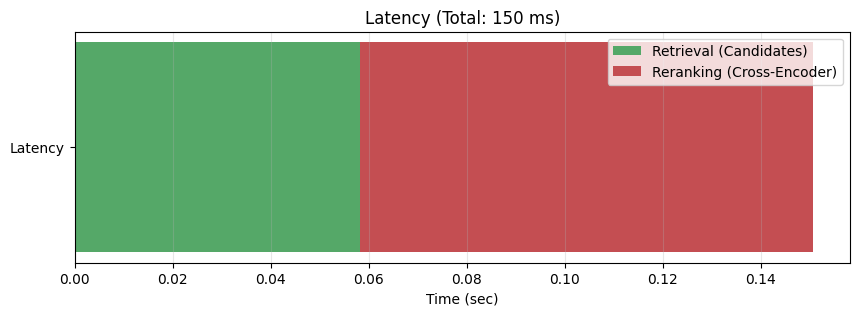

np.float64(0.9380499999999999)

In [11]:
profile_reranking_system(test_df, vectorstore, reranker)

In [12]:
import random

def print_search_examples(test_df, vectorstore, reranker, n_examples=3):
    """
    Shows n_examples random quaries and the found articles for them.
    """
    print(f"demonstration for {n_examples} random quaries\n")

    sample_rows = test_df.sample(n_examples)

    for i, (index, row) in enumerate(sample_rows.iterrows()):
        query = row['query']
        target_id = str(row['id']).strip()

        print(f"Query: {query}")
        print(f"Target ID: {target_id}")
        print("-" * 30)

        candidates = vectorstore.similarity_search(query, k=20) # Retrieval

        pairs = [[query, doc.page_content] for doc in candidates] # Reranking
        scores = reranker.predict(pairs)

        doc_score_pairs = list(zip(candidates, scores)) # sorting
        sorted_docs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

        top_5 = sorted_docs[:5] # shows top 5 found articles

        for rank, (doc, score) in enumerate(top_5):
            found_id = str(doc.metadata.get('id', '')).strip()
            title = doc.metadata.get('title', 'No Title')

            status = " correct " if found_id == target_id else " wrong "

            print(f"Rank {rank+1} ({status}): [Score: {score:}]")
            print(f"ID: {found_id}")
            print(f"Title: {title}")
            print(f"  Text: {doc.page_content[:100]}...")
            print("\n")

print_search_examples(test_df, vectorstore, reranker)

demonstration for 3 random quaries

Query: How can 3D assets with complex shading be efficiently rendered without requiring extensive shader implementations?
Target ID: 2312.09398
------------------------------
Rank 1 ( correct ): [Score: 4.301592826843262]
ID: 2312.09398
Title: RNA: Relightable Neural Assets
  Text: RNA: Relightable Neural Assets.   High-fidelity 3D assets with materials composed of fibers (includi...


Rank 2 ( wrong ): [Score: -3.1232354640960693]
ID: 2311.09806
Title: EvaSurf: Efficient View-Aware Implicit Textured Surface Reconstruction
  Text: EvaSurf: Efficient View-Aware Implicit Textured Surface Reconstruction.   Reconstructing real-world ...


Rank 3 ( wrong ): [Score: -5.624241352081299]
ID: 2309.07122
Title: Tree-Structured Shading Decomposition
  Text: Tree-Structured Shading Decomposition.   We study inferring a tree-structured representation from a ...


Rank 4 ( wrong ): [Score: -6.67085599899292]
ID: 2406.06216
Title: Lighting Every Darkness with 3DGS: